In [2]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']

2000 2000


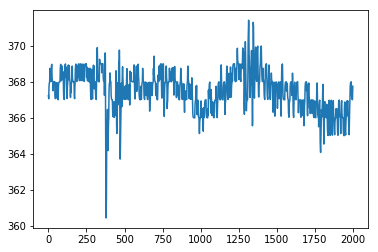

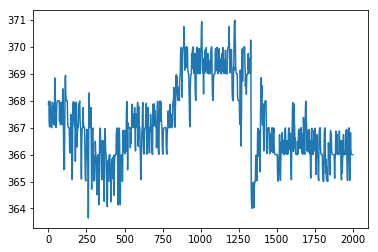

In [4]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 4000
border = 6000
num = 8000
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

1999


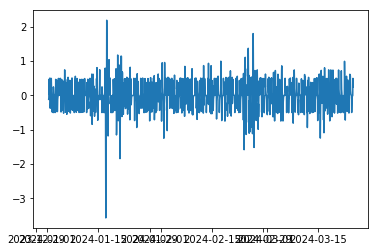

In [31]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
df1['time'] = df1['time'].diff()
df1['flow1'] = df1['flow1'].diff()
df1.dropna(inplace = True)
df1.index = pd.date_range(start='2024-01-01 10:00:00', end = '2024-03-24 16:00:00', freq='h')
#df1.index = df1['time']
print(len(df1))
plt.plot(df1['flow1'])

0 days 00:00:00


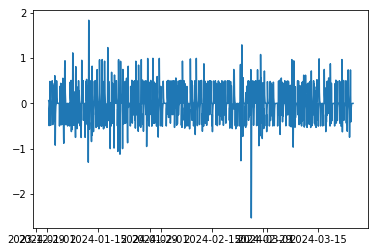

In [28]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2['time'] = df2['time'].diff()
df2['flow1'] = df2['flow1'].diff()
df2.dropna(inplace = True)
df2.index = pd.date_range(start='2024-01-01 10:00:00', end = '2024-03-24 16:00:00', freq='h')
#df2.index = df1['time']
print(df2['time'][0])
plt.plot(df2['flow1'])

In [42]:
model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=(1, 1, 1), seasonal_order=(2, 1, 1, 18))
result1 = model1.fit(disp = False)

prog_start = 0

pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
forecast_values1 = pred1.predicted_mean

In [43]:
difference = np.mean(forecast_values1 - df2['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.3634491726351109 -0.00014290838824699884


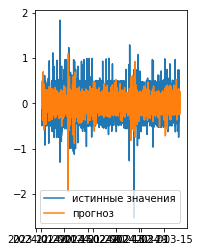

In [44]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df2['flow1'], label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()

In [47]:
def params_optimization(dataset, dataset_test, seasonal, non_seasonal, cycles):
    for i in range (10, cycles):
        seasonal[3] = i
        try:
            model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=(1, 1, 1), seasonal_order=(2, 1, 1, i))
            result1 = model1.fit(disp = False)
        except:
            continue
        pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
        forecast_values1 = pred1.predicted_mean
        difference = np.mean(forecast_values1 - dataset_test)
        forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
        print(seasonal, difference, forecast_mse_temp)  
    return [difference, forecast_mse_temp]
    

In [48]:
params_non_seasonal = [1, 1, 1]
params_seasonal = [2, 1, 1, 10]
print(params_optimization(df1, df2['flow1'], params_seasonal, params_non_seasonal, 27))


[2, 1, 1, 10] -0.0013326454284102926 0.3640298045275576
[2, 1, 1, 11] -0.0012024673270218734 0.3625304142628372
[2, 1, 1, 12] -0.000722443110402265 0.3657300459022771
[2, 1, 1, 13] -0.0005430293792567973 0.36563097834763586
[2, 1, 1, 14] -0.0007283376996183798 0.36621537377575314
[2, 1, 1, 15] -0.0003646227996694442 0.3646636046025281
[2, 1, 1, 16] -0.00018769824923762607 0.3651978856138604
[2, 1, 1, 17] 0.00024426207082923454 0.36459558876691883
[2, 1, 1, 18] -0.00014290838824699884 0.3634491726351109
[2, 1, 1, 19] -0.0006497593725976675 0.36475963362588254
[2, 1, 1, 20] -0.0007761988863735366 0.3674213019223261
[2, 1, 1, 21] -0.0008480390248338741 0.3642982526813208
[2, 1, 1, 22] -0.001744474058521351 0.36520512809711264
[2, 1, 1, 23] -0.000831750643592633 0.3690114422547741
[2, 1, 1, 24] -0.0005936109592145399 0.36914953242593185
[2, 1, 1, 25] -0.0006469048615440756 0.3654578801569819
[2, 1, 1, 26] -0.00048392164860257253 0.3674476285437502
[-0.00048392164860257253, 0.36744762854375

In [12]:
print(params_seasonal, params_non_seasonal)

[2, 1, 1, 10] [1, 1, 1]
